<h1>CS4618: Artificial Intelligence I</h1>
<h1>Training a Convolutional Neural Network</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [246]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

<h1>Acknowledgement</h1>
<ul>
    <li>This lecture, including the code, is based closely on sections 5.2 and 5.3 of: 
        Fran&ccedil;ois Chollet: <i>Deep Learning with Python (1st edition)</i>,
        Manning Publications, 2018
    </li>
    <li>The diagram is based closely on Figure 11-4 in: A. G&eacute;ron: 
        <i>Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (2nd edn)</i>, O'Reilly, 2019
    </li>
</ul>

<h1>Warning</h1>
<ul>
    <li>It will probably be impossible for you to run the code in this notebook in one go. Even on Google Colab, it may take an hour or so.
    </li>
</ul>

<h1>It's Raining Cats and Dogs</h1>
<ul>
    <li>There is a dataset, supplied by Microsoft researchers, for a Kaggle competition:
        <a href="https://www.kaggle.com/c/dogs-vs-cats">https://www.kaggle.com/c/dogs-vs-cats</a>
        <ul>
            <li>12,500 medium-resolution JPEGs depicting cats and 12,500 depicting dogs.</li>
        </ul>
    </li>
    <li>We use a subset of the full dataset:
        <ul>
            <li>training set: 1000 cats and 1000 dogs;</li>
            <li>validation set: 500 cats and 500 dogs;</li>
            <li>test set: 500 cats and 500 dogs.</li>
        </ul>
    </li>
</ul>

In [248]:
base_dir = "../datasets/dataset_cats_and_dogs"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

<ul>
    <li>Let's look at one of the dogs:</li>
</ul>

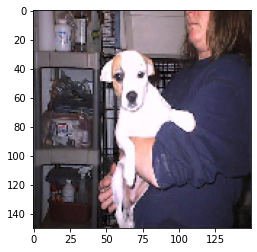

In [249]:
train_dogs_dir = os.path.join(train_dir, "dogs")
filenames = [os.path.join(train_dogs_dir, filename) for filename in os.listdir(train_dogs_dir)]

idx = 303 # Change this if you want to look at a different dog
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

<h2>Data Preprocessing</h2>
<ul>
    <li>Keras gives us an extremely useful function: <code>image_dataset_from_directory</code>. It has
        lots of arguments, some of which are explained here:
        <ul>
            <li><code>directory</code>: where the data is located.</li>
            <li><code>labels</code>: the default is "inferred", meaning the labels are taken from the 
                directory structure.
            </li>
            <li><code>label_mode</code>: Either "int" (default), meaning that the labels should be encoded as integers 
                (in which case, use sparse_categorical_crossentropy loss), or "categorical", meaning that 
                the labels should be one-hot encoded (in which case, use categorical_crossentropy loss) or "binary",  
                meaning that there are two labels to be encoded as 0 or 1 (in which case, use binary_crossentropy),
                or "None", no labels.
            </li>
            <li><code>color_mode</code>: either "grayscale", "rgb" (default) or "rgba". Images will be converted to 
                have 1, 3, or 4 channels, based on the value you give.
            </li>
            <li><code>batch_size</code>: With this argument, we can read in and process the dataset in 
                mini-batches, rather than reading the whole dataset into main memory. Its default value is 32.
            </li>
            <li><code>image_size</code>: A dataset may contain images of different sizes. The neural network
                won't works with these, so they must be resized to be all the same size. The default is 
                $256 \times 256$.
            </li>
            <li><code>shuffle</code>: Whether to shuffle the data (default is True).</li>
            <li><code>seed</code>: Optional random seed for shuffling (default is None).</li>
            <li><code>validation_split</code> and <code>subset</code>: We have an explicit folder containing our
                validation dataset, so we do not use these two arguments. But if you had all the development data 
                in one folder, then you can use these arguments to arrange for part of it to be used as validation
                data.
            </li>
            <li>...and a few more.</li>
        </ul>
    </li>
    <li>This function will decode images from one format into the format that we want, naemly a grid with a certain
        number of channels. For example, if the raw images are JPEGs, it will decompress them.
    </li>
    <li>Mostly, its default values for the arguments are what we want. Often you only need to think about
        the <code>directory</code> and the <code>label_mode</code>.
    </li>
</ul>

In [250]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary", image_size=(224, 224))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


<h2>Creating the ConvNet</h2>
<ul>
    <li>Since the images are bigger than the MNIST ones, we use a network with more layers
    </li>
</ul>

In [251]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [252]:
convnet.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 52, 52, 64)        737

<h2>Training and Testing</h2>
<ul>
    <li>We'll use more epochs than before, but still with early stopping.</li>
    <li>Warning: might take some time!</li>
</ul>

In [253]:
convnet_history = convnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<AxesSubplot:>

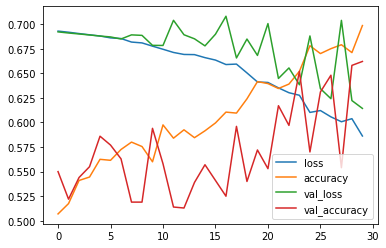

In [254]:
pd.DataFrame(convnet_history.history).plot()

<ul>
    <li>You would tweak and tune until you were happy with your model.</li>
</ul>

<h1>Data Augmentation</h1>
<ul>
    <li>With so few examples, overfitting is a major concern.</li>
    <li>We know all sorts of things we can try in order to reduce the overfitting.
        <ul>
            <li>We'll add a dropout layer below.</li>
        </ul>
    </li>
    <li>Another way to reduce overfitting is to get more examples but here we do something similar: 
        <b>data augmentation</b>.
        <ul>
            <li>We augment the training set with examples that we <em>synthesize</em> from the existing 
                training set.
            </li>
            <li>It's relatively easy when the dataset consists of images to use transformations
                on existing images to synthesize believable-looking new images.
            </li>
            <li>Be aware that this is not as good as additional real examples.
                <ul>
                    <li>These synthesized examples are correlated with each other and the originals
                        from which they were generated.
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>In Keras, we add various layers to perform data augmentation. 
    </li>
    <li>These layers will only augment the training data, not the validation or test data.</li>
</ul>

In [255]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
augmenttation_layers = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)

<ul>
    <li>You can look-up the details in the Keras API 
        documentation, but a quick summary is:
        <ul>
            <li>We may flip. For cat and dog images, only horizontal flipping makes sense.</li>
            <li>We may rotate. Here the rotations are random in the range $[-0.1 \times 2\pi, 0.1 \times 2\pi]$.
                (Recall radians from school: $2 \times \pi$ is a full circle.)
            </li>
            <li>We may zoom. Here aspect ratio is preserved because we only specify a height factor.
                Negtaive means zooming in; positive means zooming out.
            </li>
            <li>And we may shift. Here, we've asked for left/right shifts of up to 20% and up/down shifts
                of up to 20%.
            </li>
        </ul>
    </li>
</ul>

<ul>
    <li>Let's steal some code from Chollet's book (2nd edition) to see the effect of these
        transformations. This allows us to check that we are producing 'reasonable' synthetic images.
    </li>
</ul>

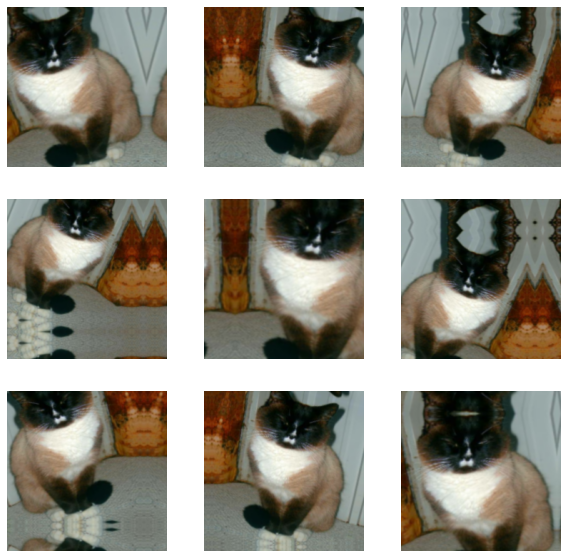

In [256]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

<ul>
    <li>So now let's add those layers to our network.</li>
</ul>

In [257]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
x = Rescaling(scale=1./255)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
augmented_model = Model(inputs, outputs)
augmented_model.compile(optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

<ul>
    <li>So now let's train. We can run for more epochs.</li>
</ul>

In [258]:
augmented_model_history = augmented_model.fit(train_dataset, epochs=60, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<AxesSubplot:>

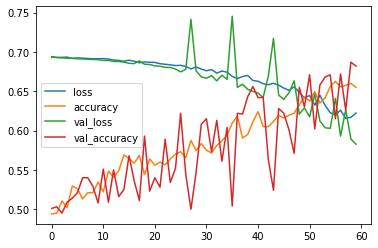

In [259]:
pd.DataFrame(augmented_model_history.history).plot()

<h2>Some predictions</h2>
<ul>
    <li>Let's read in some images, display them, and see what the model predicts.
    </li>
</ul>

In [260]:
demo_dataset = image_dataset_from_directory(
    directory="../datasets/dataset_wikipedia_images/", shuffle=False, label_mode=None, image_size=(224, 224), )

Found 4 files belonging to 1 classes.


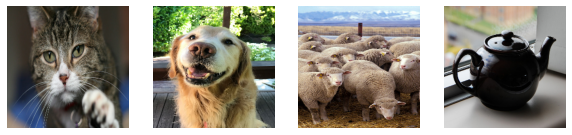

In [261]:
plt.figure(figsize=(10, 10))
for batch in demo_dataset:
    for i, img in enumerate(batch):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")

In [262]:
augmented_model.predict(demo_dataset) # Class 0 is cat and class 1 is dog (alphabetic)

array([[0.2714722 ],
       [0.912008  ],
       [0.60411197],
       [0.64215696]], dtype=float32)

<h1>Pretrained Convolutional Neural Networks</h1>
<ul>
    <li>A <b>pretrained network</b> is a saved network that was trained, usually on a large dataset.</li>
    <li>Remarkably, these are increasingly being made available for image classification, speech
        recognition and other tasks.
    </li>
    <li>Consider the ImageNet dataset (<a href="http://www.image-net.org/">http://www.image-net.org/</a>):
        <ul>
            <li>1.4 million images, each manually labeled with one class per image;</li>
            <li>thousands of classes, mostly animals and everyday objects;</li>
            <li>annual competitions (ImageNet Large Scale Visual Recognition Challenges, ILSVRC), now
                hosted on Kaggle.
            </li>
        </ul>
    </li>
    <li>There are several pretrained neural networks for ImageNet, half a dozen of which are made
        available directly in Keras, including
        <ul>
            <li>VGG16 and VGG19;</li>
            <li>ResNet50 and ResNet101;</li>
            <li>Inception V3.</li>
        </ul>
    </li>
    <li>
        These networks incorporate a number of innovations, which we don't have time to study in depth,
        including
        local response normalization,
        <!-- where strongly activated neurons in one feature map can inhibit
             neurons in the same position in neighbouring feature maps, which encourages feature maps
             to specialize.
        -->
        skip connections,
        <!-- where the input into one layer is also added to the output of a layer a bit
             higher up the stack. This means that the later layer must in effect learn the difference 
             (residual) between what it would have learned and the amount that has been added. This
             boosts the signal across the network, which can encourage learning.
        -->
        inception modules, 
        <!-- where (roughly) there are multiple convolutions with different window
             sizes operating at the same level of the network, making the network wider rather than
             deeper. They help reduce dimensionality and result in networks with fewer parameters.
        -->
        and depthwise separable convolutional layers.
        <!-- where (roughly) there are convolutional layers
             whose neurons connect to only one feature map in the layer below (to detect spatial 
             patterns) and then regular convolutional layers (but with $1 \times 1$ windows) that look 
             for patterns between the feature maps of the spatial layer.
        -->
        Every year sees further innovations. Many are trying to find better ways of learning how objects
        are composed of smaller parts; for one example, see capsules.
    </li>
    <li>In this lecture, we'll see how to use a pretrained network (ResNet50) for <b>transfer learning</b>:
        using it as the lower layers of our own network.
        <ul>
            <li>(We'll use ResNet50 in the demo code below, but some students have found they get more stable results
                using something different from ResNet50, e.g VGG16. It easy to change the demo code to use
                VGG16 instead iof ResNet50.)
            </li>
        </ul>
    </li>
</ul>

<h1>ResNet50</h1>
<ul>
    <li>Compare its base with the full network.</li>
</ul>

In [263]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [264]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_40[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [265]:
resnet50 = ResNet50(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

In [266]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_41[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

<ul>
    <li>Let's see what ResNet50 predicts 
        for the four images from earlier.
    </li>
</ul>

In [267]:
predictions = resnet50.predict(demo_dataset)
decode_predictions(predictions, top=3)

[[('n02123159', 'tiger_cat', 0.38074815),
  ('n02123045', 'tabby', 0.34231877),
  ('n02124075', 'Egyptian_cat', 0.12753892)],
 [('n02105412', 'kelpie', 0.41296503),
  ('n02099712', 'Labrador_retriever', 0.19615678),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.10481418)],
 [('n02412080', 'ram', 0.810332),
  ('n02444819', 'otter', 0.040895443),
  ('n02396427', 'wild_boar', 0.025923006)],
 [('n04398044', 'teapot', 0.99999344),
  ('n03063689', 'coffeepot', 6.545854e-06),
  ('n04560804', 'water_jug', 1.7925755e-08)]]

<h1>Transfer Learning</h1>
<ul>
    <li><b>Transfer learning</b>:
        <ul>
            <li>taking a model that was learned when solving one problem and <em>re-using</em> it for solving
                a different but related problem.
            </li>
        </ul>
    </li>
    <li>Advantages:
        <ul>
            <li>it speeds-up training for the new problem;</li>
            <li>it means that less training data may be needed for the new problem.</li>
        </ul>
    </li>
    <li>Deep neural networks are more amenable to transfer learning than many other machine learning
        techniques:
        <ul>
            <li>take a pre-trained network;</li>
            <li>re-use its lower layers, even <b>freezing</b> their weights.</li>
        </ul>
        <figure>
            <img src="images/transfer.png" />
        </figure>
    </li>
    <li>E.g.
        <ul>
            <li>We have several networks that are pre-trained on ImageNet, including ResNet50:
                <ul>
                    <li>trained to classify images into 1000 classes (various animals, vehicles, etc.).</li>
                </ul>
            </li>
            <li>We can re-use the lower layers in a new network that is trained to classify images 
                of just cats and dogs, or different types of vehicles, or for face recognition, or
                perhaps even facial expression recognition.
            </li>
        </ul>
    </li>
    <li>Of course, this will only work well if the original and new tasks share similar low-level features.
        <ul>
            <li>The more similar the new problem is to the original problem, the more layers we may want to
                re-use.
            </li>
        </ul>
    </li>
</ul> 

<h2>Re-using the Convolutional Base of a Pretrained ConvNet</h2>
<ul>
    <li>Convolutional Neural Networks typically comprise two parts:
        <ul>
            <li>the <b>convolutional base</b>: the convolutional and pooling layers;</li>
            <li>the densely-connected top layers for, e.g. classification.</li>
        </ul>
    </li>
    <li>We want to reuse the convolutional base:
        <ul>
            <li>the features learned by these layers are likely to be more generic;</li>
            <li>the features learned by the top layers will be more specific to the original task.</li>
        </ul>
    </li>
</ul>

<h2>It's Raining Cats and Dogs, again</h2>
<ul>
    <li>We'll re-use the convolutional base of the ResNet50 model within a new network for
        classifying cats and dogs. 
    </li>
    <li>We create our new network but we add the pre-trained convolutional base of the ResNet50 model, 
        just as we would add a layer.
    </li>
    <li>We can precede it by a function to preprocess the data into a form that ResNet50 expects.
        This even allows us to exclude the Rescaling layer.
    </li>
    <li>We could even add the aumentation layesr if we wanted.</li>
</ul>

In [268]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet50_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
transfer_model = Model(inputs=inputs, outputs=outputs)

<ul>
    <li>We <b>feeze</b> the weights in the layers of the convolutional base. If we did not, 
        then the features that ResNet50 learned previously would be lost.
    </li>
</ul>

In [269]:
for layer in resnet50_base.layers:
    layer.trainable = False

In [270]:
transfer_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_23 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
________________________________________

<ul>
    <li>Now we can compile, and train.</li>
</ul>

In [271]:
transfer_model.compile(optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [272]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<AxesSubplot:>

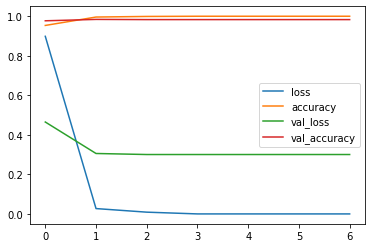

In [273]:
pd.DataFrame(transfer_model_history.history).plot()

<h2>Unfreezing Parts of the Convolutional Base</h2>
<ul>
    <li>Now that our new top layesr are well-trained, we can unfreeze all layers in the base (or just the
        top ones in the base) and contnue training.
    </li>
</ul>

In [274]:
for layer in resnet50_base.layers:
    layer.trainable = True

In [275]:
transfer_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_23 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 23,634,945
Non-trainable params: 53,120
_________________________________________

<ul>
    <li>In Keras, re-compilation is needed at this point. (We re-compile, but we do not build a new model.
        The whole idea is to continue to tune the one we've already built.)
    </li>
    <li>You probably want a lower learning rate to avoid damaging the pretrained weights.
        <ul>
            <li>One could even imagine different learning rates for different layers:
                smaller ones at the bottom of the base than at the top of the base.
            </li>
        </ul>
    </li>
</ul>

In [276]:
transfer_model.compile(optimizer=SGD(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

<ul>
    <li>So now resume training.</li>
</ul>

In [277]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<AxesSubplot:>

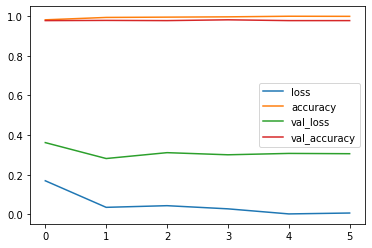

In [278]:
pd.DataFrame(transfer_model_history.history).plot()

<h1>Testing</h1>
<ul>
    <li>Let's test them all on the test set.</li>
</ul>

In [279]:
# The original convnet
test_loss, test_acc = convnet.evaluate(test_dataset)
test_acc

32/32 [==============================] - 19s 583ms/step - loss: 0.6290 - accuracy: 0.6400


0.6399999856948853

In [280]:
# The convnet with dropout, trained using data augmentation
test_loss, test_acc = augmented_model.evaluate(test_dataset)
test_acc

32/32 [==============================] - 19s 585ms/step - loss: 0.6088 - accuracy: 0.6790


0.6790000200271606

In [281]:
# The convnet that was trained and tuned using transfer learning
test_loss, test_acc = transfer_model.evaluate(test_dataset)
test_acc

32/32 [==============================] - 36s 1s/step - loss: 0.4040 - accuracy: 0.9790


0.9789999723434448

<ul>
    <li>Above, we froze and then unfroze all the layers of the pretrained convolutional base.</li>
    <li>There is some discussion in the literature about this. In particular, should the Batch Normalization
        layers be frozen. If you are having trouble geeting transfer learning to work, then this might be
        something worth reading about. However, if you are using Keras, then it is supposed to already
        make the correct decisions: it only freezes parameters that are affected by gradient descent.
    </li>
</ul>

<h1>Saving and Restoring Models</h1>
<ul>
    <li>Having learned the weights, we should save a model so that we don't have to learn them again!</li>
    <li><code>save</code> is a method that saves a Keras model (network, weights, training configuration,
        state of the optimizer) into a HDF5 file.
    </li>
    <li><code>load_model</code>: reinstantiates the model, including compiling the model using the saved 
        training configuration.
    </li>
</ul>

In [282]:
transfer_model.save("models/my_model.h5")

/Users/dgb/Dropbox/AI/venv/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [283]:
reloaded_model = load_model("models/my_model.h5")

<h1>Concluding Remarks</h1>
<ul>
    <li>It's often said that we need lots of data for deep learning.</li>
    <li>But transfer learning helps us in cases where we have more limited data.</li>
    <li>E.g. we want to do face recognition but we have only a few pictures of each person,
        not enought to train a good classifier:
        <ul>
            <li>Collect loads of pictures of faces of random people from the web.</li>
            <li>Train a network to detect whether or not two different pictures portray the same person.</li>
            <li>This network is presumably a good feature detector for faces.</li>
            <li>Use this network as the lower layers of your face recognition classifier.</li>
        </ul>
    </li>
    <li>E.g. we want to do some natural language processing but we don't have a large dataset.
        <ul>
            <li>Collect loads of sentences from the web, label them 'good'.</li>
            <li>Corrupt these sentences in various ways, and label them 'bad'.</li>
            <li>Train a network to classify sentences and non-sentences ('good' vs. 'bad').</li>
            <li>Use this network as the lower layers of your natural language processing system.</li>
        </ul>
    </li>
</ul>